### import packages

In [4]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import os
import time

### data preprocess

In [2]:
# 数据预处理，做一些scale，随机crop，normalizaiotn到0-1之间
img_transform = {
    'train': transforms.Compose([
            transforms.Scale(300),
            transforms.CenterCrop(224),
            transforms.ToTensor()
#             transforms.Normalize((0, 0, 0), (255, 255, 255))
        ]),
    'val': transforms.Compose([
#             transforms.Scale(300),
            transforms.CenterCrop(160),
            transforms.ToTensor()
#             transforms.Normalize((0, 0, 0), (255, 255, 255))
        ])
}

root_path = '../data'

#读取数据文件夹
dset = {
    'train': ImageFolder(os.path.join(root_path, 'train/province'), transform=img_transform['train']),
    'val': ImageFolder(os.path.join(root_path, 'val/province'), transform=img_transform['val'])
}

#读取数据
dataloader = {
    'train': DataLoader(dset['train'], batch_size=16, shuffle=True, num_workers=4),
    'val': DataLoader(dset['val'], batch_size=16, num_workers=4)
}

# img, label = iter(dataloader['train']).next()

# a = img[0].numpy()
# a = np.transpose(a, (1, 2, 0))
# plt.imshow(a)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

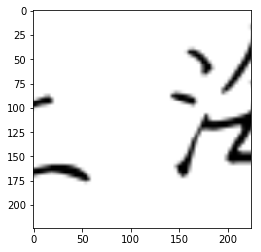

In [7]:
img, label = iter(dataloader['train']).next()

a = img[0].numpy()
a = np.transpose(a, (1, 2, 0))
plt.imshow(a)

In [3]:
#确定数据size
data_size = {
    x: len(dataloader[x].dataset.imgs)
    for x in ['train', 'val']
}

In [4]:
print('size of train data set: {}'.format(data_size['train']))# 每个文件夹放了一张图片做一个示例
print('size of validation data set: {}'.format(data_size['val']))

size of train data set: 300
size of validation data set: 300


In [5]:
img_classes = dataloader['train'].dataset.classes

In [6]:
# 创建了三个省份作为示例，顺序按照文件夹的顺序
print('class of province: {}'.format(img_classes))

class of province: ['anhui', 'guangdong', 'jiangsu', 'shanghai', 'sichaun', 'zhejiang']


In [7]:
#判断能不能用cuda，增加鲁棒性
use_gpu = torch.cuda.is_available()

In [8]:
print("in my computer, cuda availabel? \n{}".format(use_gpu))

in my computer, cuda availabel? 
True


## build vgg net
之所以选择vgg因为这个问题不需要太复杂的网络，所以选择了一个相对简单的网络结构  
详细网络结构见下面网址
http://ethereon.github.io/netscope/#/gist/dc5003de6943ea5a6b8b

In [9]:
class vgg16(nn.Module):
    def __init__(self, in_c, out_class):
        super(vgg16, self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_c, 64, 3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(64, 64, 3, stride=1, padding=1),
                nn.ReLU(True)
            )
        self.conv2 = nn.Sequential(
                nn.Conv2d(64, 128, 3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(128, 128, 3, stride=1, padding=1),
                nn.ReLU(True)
            )
        self.conv3 = nn.Sequential(
                nn.Conv2d(128, 256, 3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(256, 256, 3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(256, 256, 3, stride=1, padding=1),
                nn.ReLU(True),
                nn.AvgPool2d(40)
            )
#         self.conv4 = nn.Sequential(
#                 nn.Conv2d(256, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.Conv2d(512, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.Conv2d(512, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True)
#             )
#         self.conv5 = nn.Sequential(
#                 nn.Conv2d(512, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.Conv2d(512, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True),
#                 nn.Conv2d(512, 512, 3, stride=1, padding=1),
#                 nn.ReLU(True)
#             )
        self.fc1 = nn.Linear(256, out_class)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2, stride=2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2, stride=2)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [10]:
mynet = vgg16(3, 6)
# mynet = torchvision.models.resnet101()

In [11]:
mynet

vgg16 (
  (conv1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
  )
  (conv2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
  )
  (conv3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU (inplace)
    (6): AvgPool2d (
    )
  )
  (fc1): Linear (256 -> 6)
)

In [22]:
mynet.fc = nn.Sequential(nn.Linear(2048, 1000),
                         nn.ReLU(True),
                         nn.Linear(1000, 500),
                         nn.ReLU(True),
                         nn.Linear(500, 2),
                         nn.Softmax())

In [16]:
mynet.classifier = nn.Sequential(nn.Linear(25088, 4096), 
                                 nn.ReLU(True), 
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 400),
                                 nn.ReLU(True),
                                 nn.Dropout(0.5),
                                 nn.Linear(400, 2),
                                 nn.Softmax()
                                 )

In [12]:
if use_gpu:
    mynet = mynet.cuda()

In [28]:
#print('network structure:')
#mynet

In [13]:
# define optimizer and loss
optimizer = optim.SGD(mynet.parameters(), lr=1e-3, momentum=0.9) 
# 随机梯度下降，之后可以选择别的速度更快的如rmsprop
criterion = nn.CrossEntropyLoss()

### begin train

In [14]:
num_epoch = 50

In [ ]:
for epoch in range(num_epoch):
    print(epoch)
    print('*'*10)
    running_loss = 0.0
    running_acc = 0.0
    for data in dataloader['train']:
        img, label = data
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        
        out = mynet(img)
        loss = criterion(out, label)
        _, pred = torch.max(out, 1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0] * label.size(0)
        num_correct = torch.sum(pred==label)
        running_acc += num_correct.data[0]
    running_loss /= data_size['train']
    running_acc /= data_size['train']
    print(running_loss)
    print(running_acc)
    print()

0
**********
1.7922750600179036
0.16666666666666666

1
**********
1.7922442038853963
0.16666666666666666

2
**********
1.7922274382909138
0.16666666666666666

3
**********
1.7922228797276816
0.16666666666666666

4
**********
1.792212568918864
0.16666666666666666

5
**********
1.7921974500020346
0.16666666666666666

6
**********
1.7921104113260904
0.16666666666666666

7
**********
1.7922634903589885
0.16666666666666666

8
**********
1.7921264092127482
0.16666666666666666

9
**********
1.7920837672551473
0.16666666666666666

10
**********
1.7920902872085571
0.16666666666666666

11
**********
1.7921328242619832
0.16666666666666666

12
**********
1.7920765352249146
0.16666666666666666

13
**********
1.7920086495081584
0.16666666666666666

14
**********
1.7919814888636272
0.16666666666666666

15
**********
1.7920080741246542
0.16666666666666666

16
**********
1.7919821548461914
0.16666666666666666

17
**********
1.791977710723877
0.16666666666666666

18
**********
1.7919511874516805
0.16666

In [22]:
for epoch in range(num_epoch): # 开始每个epoch
    since = time.time() # 取得当前时间
    print('{}/{}'.format(epoch+1, num_epoch))
    print('-'*10)

#     for phase in ['train', 'val']: # 判断是train还是validation
#     if phase == 'train':

    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(dataloader['train'], 1):
        img, label = data
        if use_gpu:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
        else:
            img = Variable(img)
            label = Variable(label)

        # forward
        output = mynet(img)
        _, pred = torch.max(output, 1)
        loss = criterion(output, label)
        # backward
#         if phase == 'train': # 如果是train，则反向传播更新参数

        optimizer.zero_grad() # 将梯度归零
        loss.backward()
        optimizer.step()
        # log statistics
        running_loss += loss.data[0] * label.size(0)
        num_correct = torch.sum(pred == label)
        running_acc += num_correct.data[0]
        if i % 10 == 0:
            print('{}/{}, Loss: {:.4f}, Acc:{:.4f}'.format(i//10, data_size['train']//(10*16), 
                                                   running_loss/(i*16), running_acc/(i*16)))
        
    running_loss /= data_size['train']
    running_acc /= data_size['train']
    print('{} Loss:{:.4f} Acc:{:.4f}'.format('train', running_loss, running_acc))
    time_eplise = time.time() - since
    print('complete in {:.0f}m {:.0f} s'.format(time_eplise//60, time_eplise%60))
#             if phase == 'val' and running_acc > best_acc: # 根据validation 判断更新之后的model是否更好
#                 best_acc = running_acc
#                 best_model = copy.deepcopy(model)

    print()


1/50
----------
1/1, Loss: 1.7920, Acc:0.1688
train Loss:1.7917 Acc:0.1633
complete in 0m 16 s

2/50
----------


RuntimeError: cuda runtime error (2) : out of memory at /home/sherlock/Documents/pytorch/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:

    
#     best_model = model
#     best_acc = 0.0
        
for epoch in range(num_epoch): # 开始每个epoch
    since = time.time() # 取得当前时间
    print('{}/{}'.format(epoch+1, num_epoch))
    print('-'*10)

    for phase in ['train', 'val']: # 判断是train还是validation
        if phase == 'train':
            optimizer.zero_grad() # 将梯度归零

        running_loss = 0.0
        running_acc = 0.0
        for data in dataloader[phase]:
            img, label = data
            if use_gpu:
                img = Variable(img).cuda()
                label = Variable(label).cuda()
            else:
                img = Variable(img)
                label = Variable(label)

            # forward
            output = mynet(img)
            _, pred = torch.max(output, 1)
            loss = criterion(output, label)
            # backward
            if phase == 'train': # 如果是train，则反向传播更新参数
                loss.backward()
                optimizer.step()
            # log statistics
            running_loss += loss.data[0] * label.size(0)
            num_correct = torch.sum(pred == label)
            running_acc += num_correct.data[0]

        running_loss /= data_size[phase]
        running_acc /= data_size[phase]
        print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, running_loss, running_acc))
    time_eplise = time.time() - since
    print('comlete in {:.0f}m{:.0f}s'.format(epoch+1, num_epoch,time_eplise//60, time_eplise%60))
#             if phase == 'val' and running_acc > best_acc: # 根据validation 判断更新之后的model是否更好
#                 best_acc = running_acc
#                 best_model = copy.deepcopy(model)

    print()
